# Pr&aacute;ctica 4: Sensado de señales fisiológicas

<style>
    .imagen-ajustada {
        width: 900px;
        height: 280px;
        border-radius: 20px;
    }
</style>

<img src="electro.jpg" alt="Una imagen" class="imagen-ajustada">

Esta pr&aacute;ctica tuvo como objetivo comprender como se siente una persona en una situaci&oacute;n de estres, en este caso se tuvo como prueba la presentacion de avance de proyecto de la materia de ciencia de datos para sensores inteligentes. Se sensaron los datos fisiologicos por medio de un sensor de frecuencia cardiaca Polar H10 mientras se explicaba el avance, tambien se grabo la exposicion y por ultimo los doctores hicieron preguntas que nos resultaran estresantes y asi tomar los datos requeridos.

## Librer&iacute;as Importadas

In [34]:
import os
import warnings
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split


## Manejo del dataset

En esta secci&oacute;n podemos ver que traemos los datos de cada participante para ver como son sus respectivos estados en medio de la presentaci&oacute;n.

In [2]:
path = './Fisiologico/'
list_dir = os.listdir(path=path)
fisiological_data = {}
for dir in list_dir:
    if dir.startswith("Audios"):
        continue
    file = dir.upper()
    fisiological_data[file] = pd.read_csv(path + dir +"/"+ file + ".txt", header=None, names=["RR"])

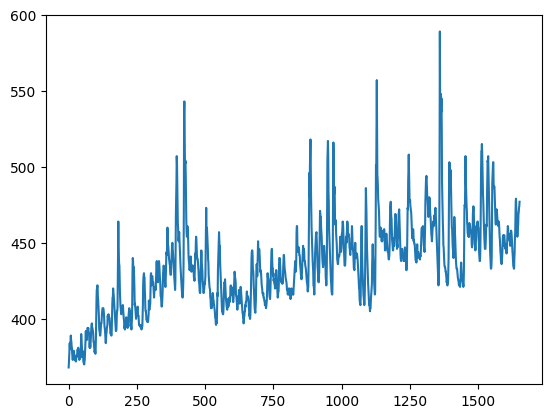

In [3]:
fisiological_data["ARIANA"]

plt.plot(fisiological_data["ARIANA"])

Al momento de ir avanzado, se pudo ver que los audios tienen acento en los nombres correspondientes, pero mejor se opto por quitarlos para evitar cualquier tipo de percance.

In [4]:
def quitar_acentos(palabra):
    palabra_normalizada = unicodedata.normalize('NFD', palabra)
    palabra_sin_acentos = ''.join(c for c in palabra_normalizada if unicodedata.category(c) != 'Mn')
    return palabra_sin_acentos

palabras_con_acentos = ["ANDRÉS", "JESÚS"]
palabras_sin_acentos = []

for palabra in palabras_con_acentos:
    palabra_sin_acento = quitar_acentos(palabra)
    palabras_sin_acentos.append(palabra_sin_acento)

print(palabras_sin_acentos)

['ANDRES', 'JESUS']


## Procesamiento de datos

Para poder comenzar con el problema, primero se tiene que segmentar los datos de forma individual, para despues tomar como analisis cada uno de ellos e ir determinando si el participantes tiene estres y en que medida.

In [5]:
def milisegundos_a_timestamp(milisegundos):
    # Convertir milisegundos a segundos
    segundos_totales = int(milisegundos // 1000)
    milisegundos_restantes = int(milisegundos % 1000)  # Convertir a entero para asegurar el formato correcto
    horas = int(segundos_totales // 3600)
    minutos = int((segundos_totales % 3600) // 60)
    segundos = int(segundos_totales % 60)
    # Formatear como HH:MM:SS.mmm donde 'mmm' son los milisegundos
    return f"{horas:02d}:{minutos:02d}:{segundos:02d}.{milisegundos_restantes:03d}"

In [6]:
for subject in fisiological_data:
    df = fisiological_data[subject]  # Para mejorar la legibilidad
    tiempoAcumulado = 0  # Reinicia para cada sujeto
    timestamps = []  # Lista para almacenar los timestamps calculados
    
    for index, row in df.iterrows():
        tiempoAcumulado += row["RR"]
        timestamp = milisegundos_a_timestamp(tiempoAcumulado)
        timestamps.append(timestamp)
    
    df["timestamp"] = timestamps  # Asignar la lista de timestamps a la columna 'timestamp' del DataFrame

In [7]:
for subject in fisiological_data:
    df = fisiological_data[subject]  # Para mejorar la legibilidad
    tiempoAcumulado = 0  # Reinicia para cada sujeto
    timestamps = []  # Lista para almacenar los timestamps calculados
    
    for index, row in df.iterrows():
        tiempoAcumulado += row["RR"]
        timestamp = milisegundos_a_timestamp(tiempoAcumulado)
        timestamps.append(timestamp)
    
    df["timestamp"] = timestamps  # Asignar la lista de timestamps a la columna 'timestamp' del DataFrame

In [8]:
df

,RR,timestamp
0,426,00:00:00.426
1,424,00:00:00.850
2,420,00:00:01.270
3,422,00:00:01.692
4,424,00:00:02.116
...,...,...
1147,459,00:08:00.353
1148,464,00:08:00.817
1149,472,00:08:01.289
1150,479,00:08:01.768


In [9]:
print()

## An&aacute;lisis Exploratorio 

In [10]:
df.head

<bound method NDFrame.head of        RR     timestamp
0     426  00:00:00.426
1     424  00:00:00.850
2     420  00:00:01.270
3     422  00:00:01.692
4     424  00:00:02.116
...   ...           ...
1147  459  00:08:00.353
1148  464  00:08:00.817
1149  472  00:08:01.289
1150  479  00:08:01.768
1151  476  00:08:02.244

[1152 rows x 2 columns]>

In [11]:
df.describe

<bound method NDFrame.describe of        RR     timestamp
0     426  00:00:00.426
1     424  00:00:00.850
2     420  00:00:01.270
3     422  00:00:01.692
4     424  00:00:02.116
...   ...           ...
1147  459  00:08:00.353
1148  464  00:08:00.817
1149  472  00:08:01.289
1150  479  00:08:01.768
1151  476  00:08:02.244

[1152 rows x 2 columns]>

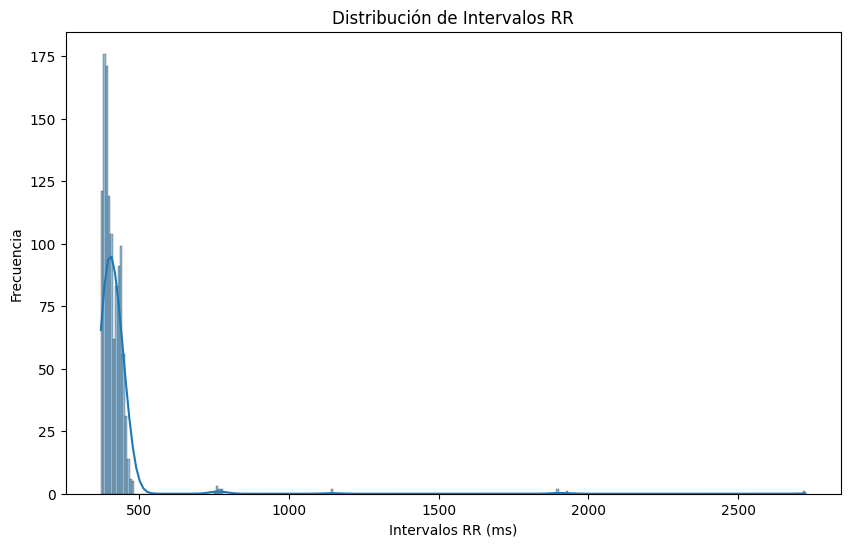

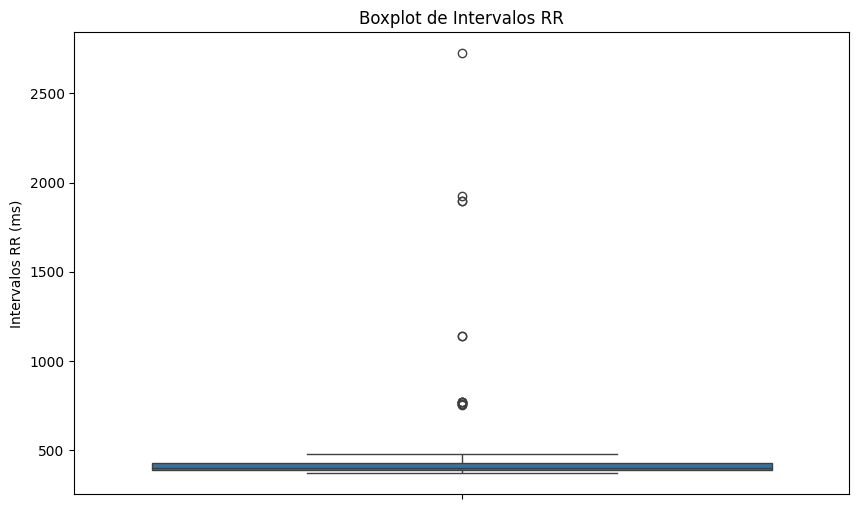

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que df es el DataFrame de un sujeto
intervalos_rr = df['RR']  # Reemplaza 'RR' con el nombre real de tu columna de intervalos RR

# Histograma
plt.figure(figsize=(10, 6))
sns.histplot(intervalos_rr, kde=True)
plt.title('Distribución de Intervalos RR')
plt.xlabel('Intervalos RR (ms)')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y=intervalos_rr)
plt.title('Boxplot de Intervalos RR')
plt.ylabel('Intervalos RR (ms)')
plt.show()


Análisis del sujeto: ANDRES
Primeras 5 filas de datos:
    RR     timestamp
0  577  00:00:00.577
1  559  00:00:01.136
2  555  00:00:01.691
3  576  00:00:02.267
4  623  00:00:02.890

Resumen estadístico:
count    1187.000000
mean      602.454928
std        52.786825
min       496.000000
25%       563.000000
50%       595.000000
75%       633.500000
max       866.000000
Name: RR, dtype: float64


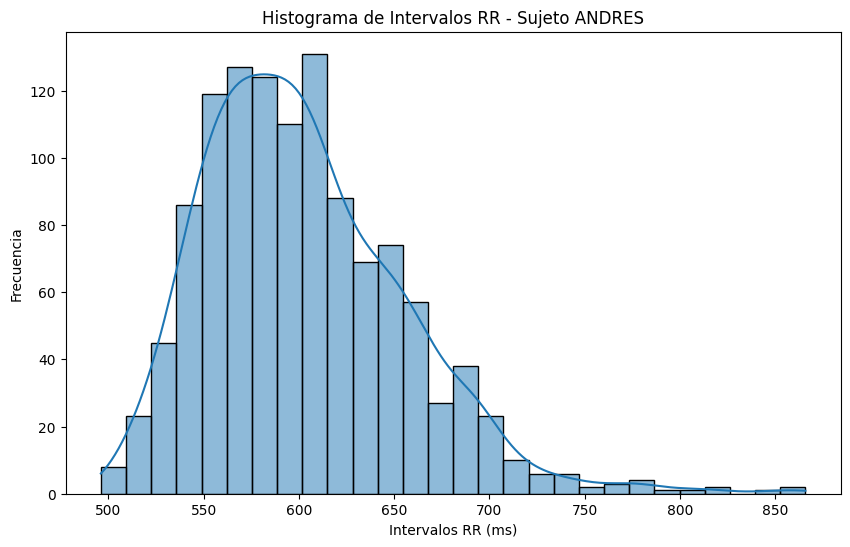

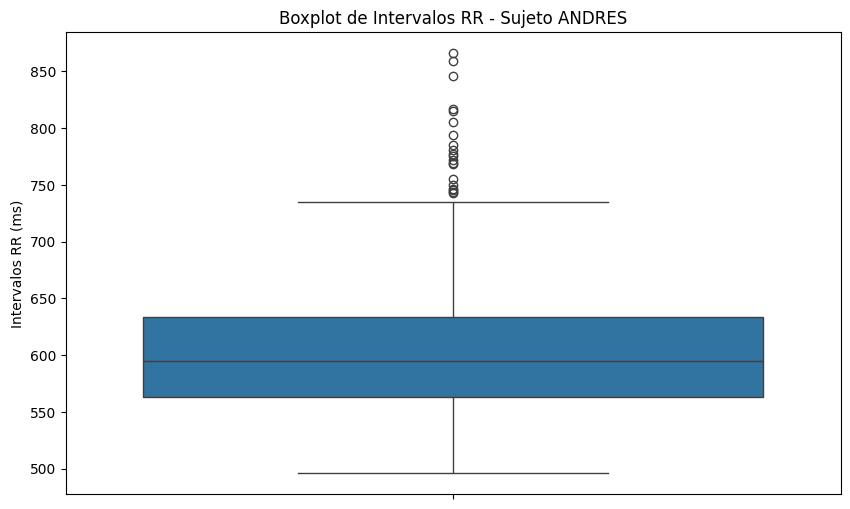

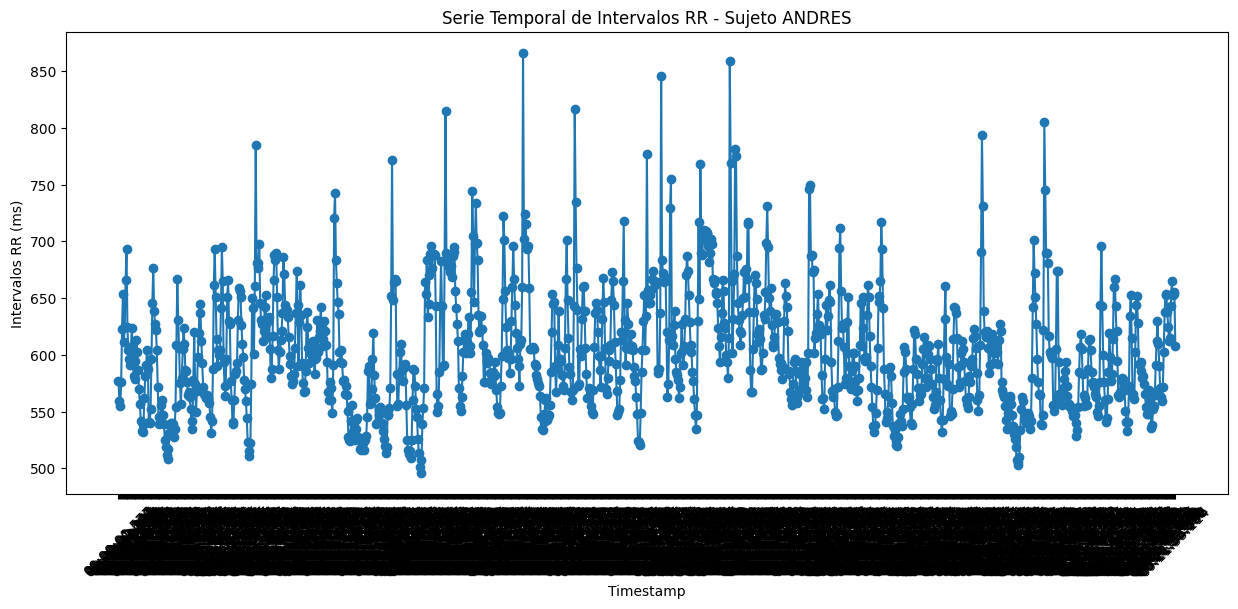

Valores nulos en los datos del sujeto ANDRES:
RR           0
timestamp    0
dtype: int64
Registros duplicados en los datos del sujeto ANDRES: 0

Análisis del sujeto: ARIANA
Primeras 5 filas de datos:
    RR     timestamp
0  368  00:00:00.368
1  371  00:00:00.739
2  376  00:00:01.115
3  381  00:00:01.496
4  384  00:00:01.880

Resumen estadístico:
count    1653.000000
mean      434.646098
std        29.511252
min       368.000000
25%       415.000000
50%       434.000000
75%       453.000000
max       589.000000
Name: RR, dtype: float64


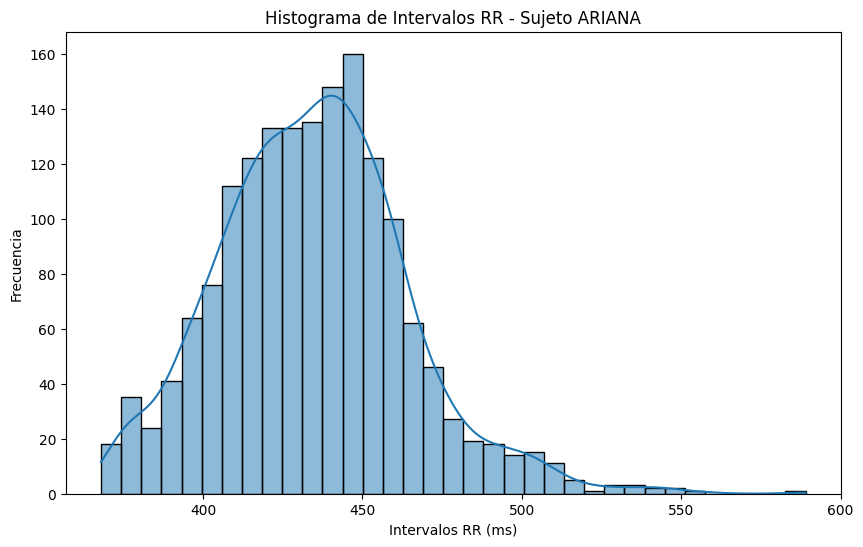

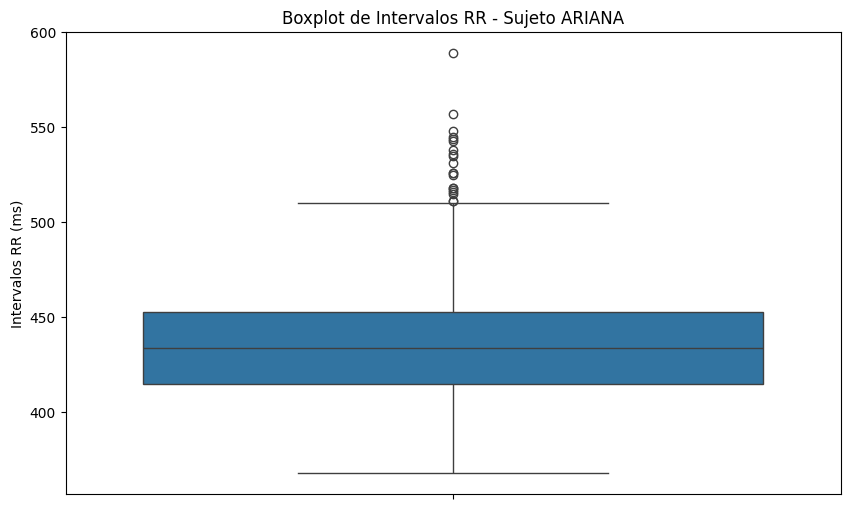

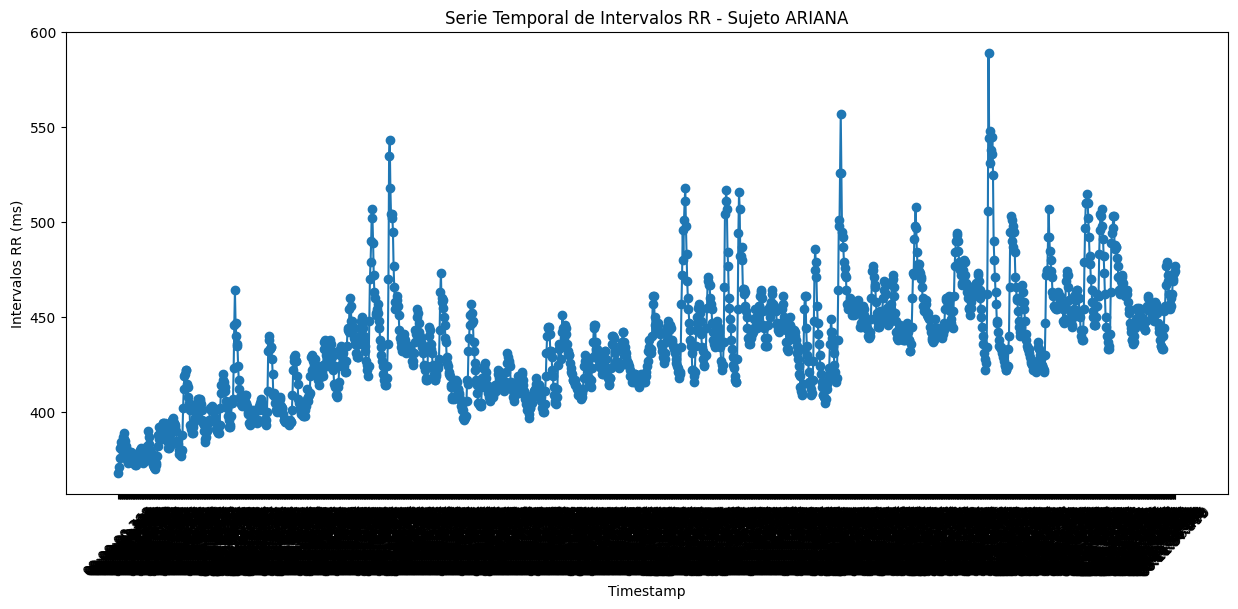

Valores nulos en los datos del sujeto ARIANA:
RR           0
timestamp    0
dtype: int64
Registros duplicados en los datos del sujeto ARIANA: 0

Análisis del sujeto: DAFNE
Primeras 5 filas de datos:
    RR     timestamp
0  504  00:00:00.504
1  497  00:00:01.001
2  491  00:00:01.492
3  502  00:00:01.994
4  364  00:00:02.358

Resumen estadístico:
count     921.000000
mean      561.836048
std        83.518966
min       345.000000
25%       507.000000
50%       555.000000
75%       613.000000
max      1200.000000
Name: RR, dtype: float64


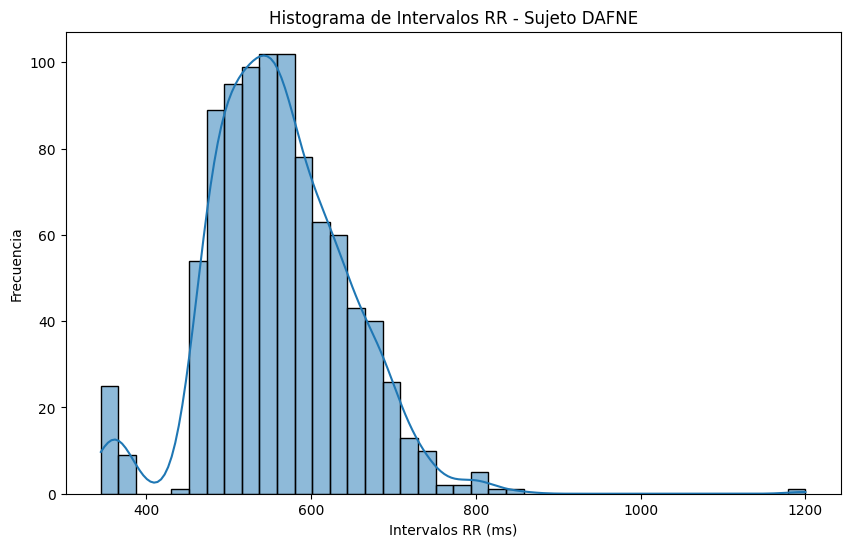

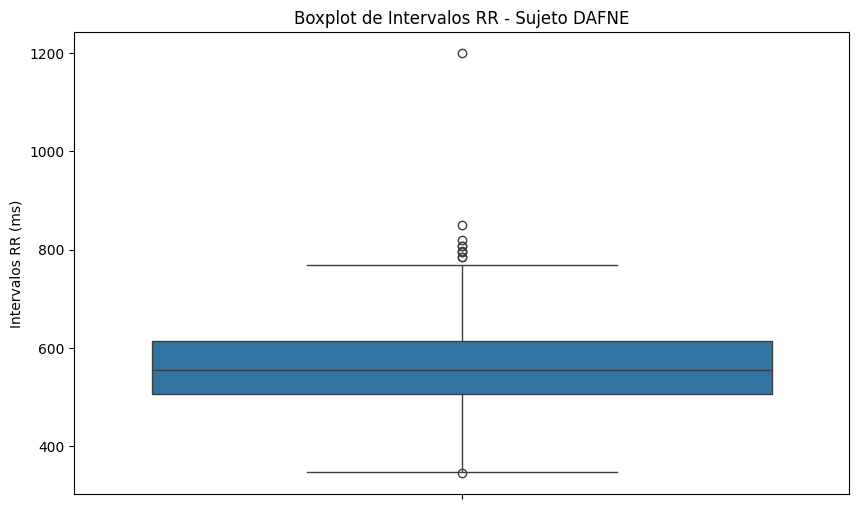

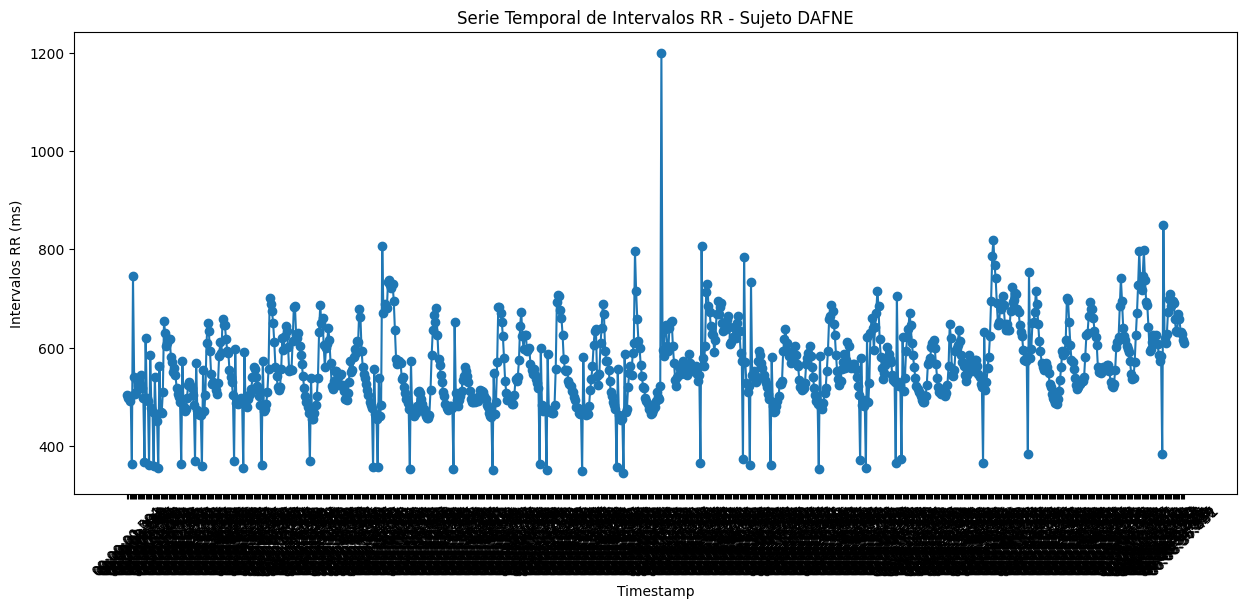

Valores nulos en los datos del sujeto DAFNE:
RR           0
timestamp    0
dtype: int64
Registros duplicados en los datos del sujeto DAFNE: 0

Análisis del sujeto: JESUS
Primeras 5 filas de datos:
    RR     timestamp
0  491  00:00:00.491
1  524  00:00:01.015
2  597  00:00:01.612
3  604  00:00:02.216
4  644  00:00:02.860

Resumen estadístico:
count    1603.000000
mean      538.205240
std        50.945011
min       424.000000
25%       501.000000
50%       531.000000
75%       568.000000
max       728.000000
Name: RR, dtype: float64


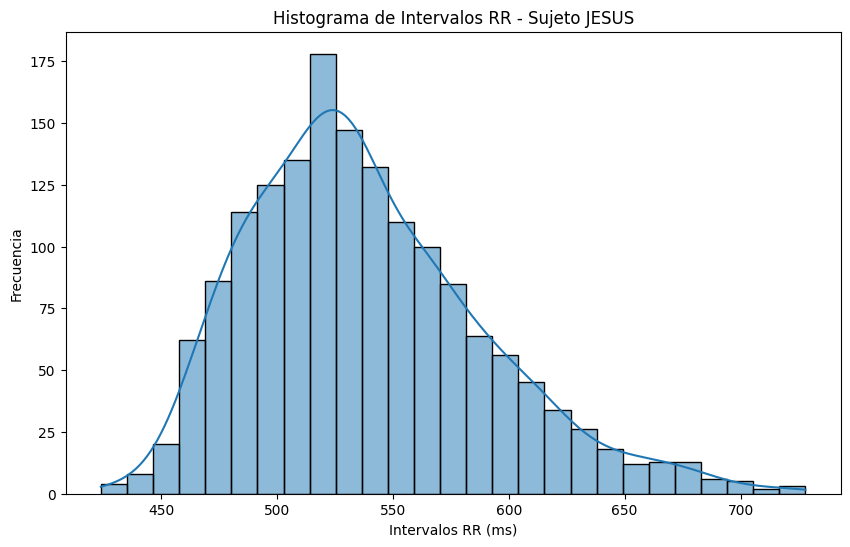

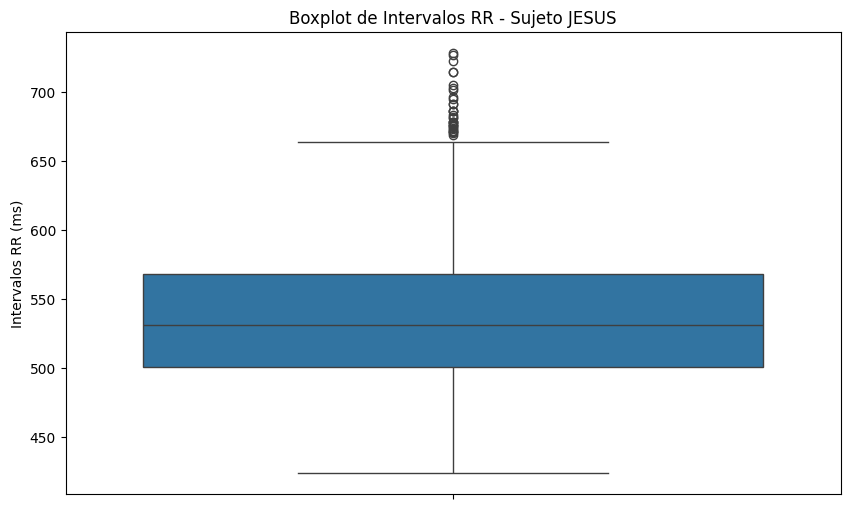

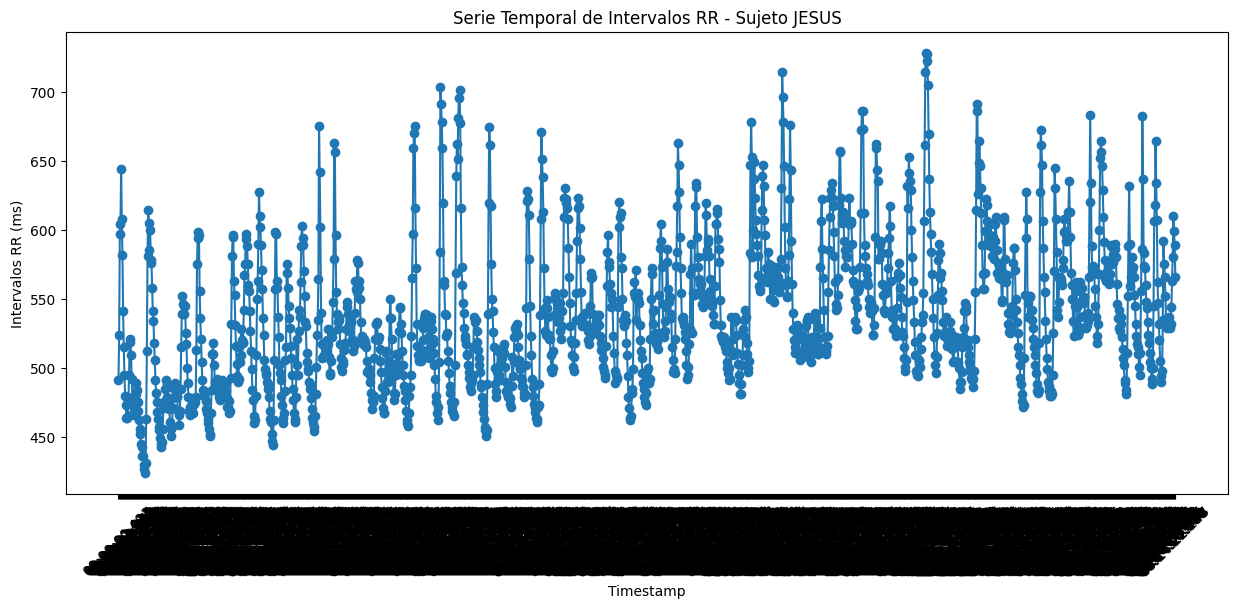

Valores nulos en los datos del sujeto JESUS:
RR           0
timestamp    0
dtype: int64
Registros duplicados en los datos del sujeto JESUS: 0

Análisis del sujeto: JUAN
Primeras 5 filas de datos:
    RR     timestamp
0  483  00:00:00.483
1  479  00:00:00.962
2  475  00:00:01.437
3  474  00:00:01.911
4  479  00:00:02.390

Resumen estadístico:
count    1007.000000
mean      501.935452
std        33.775319
min       437.000000
25%       475.000000
50%       498.000000
75%       527.500000
max       593.000000
Name: RR, dtype: float64


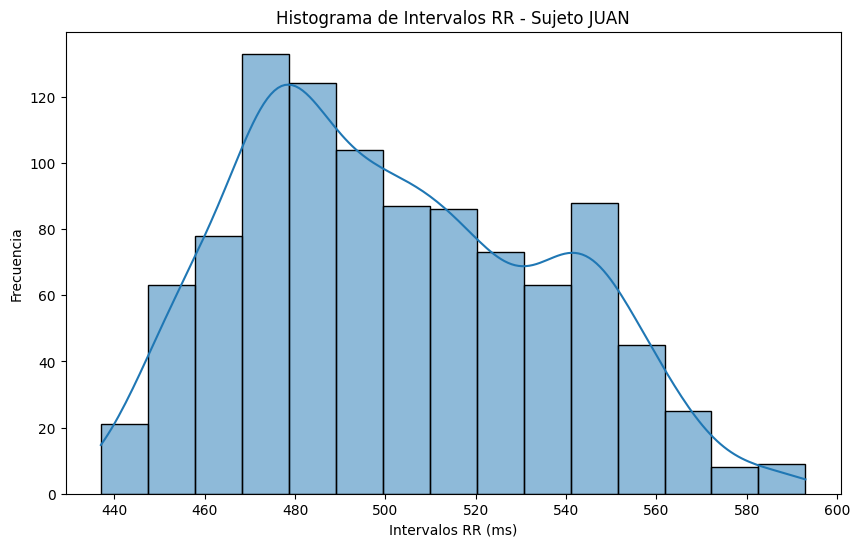

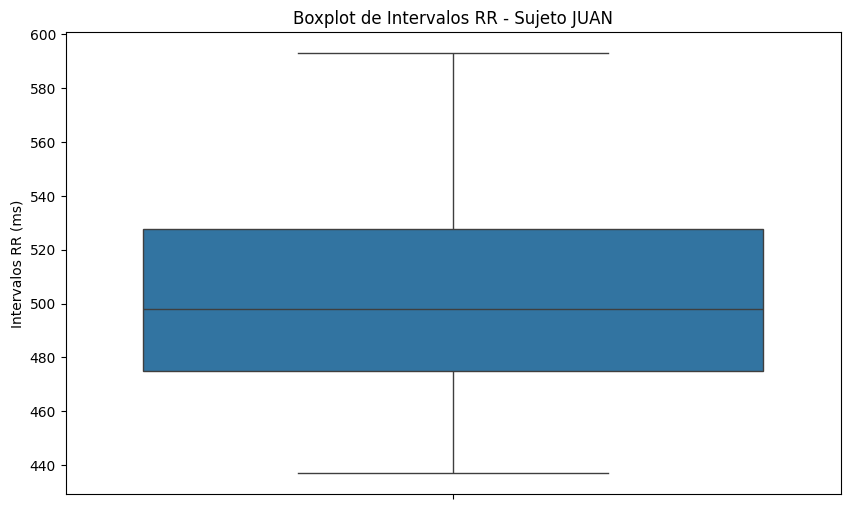

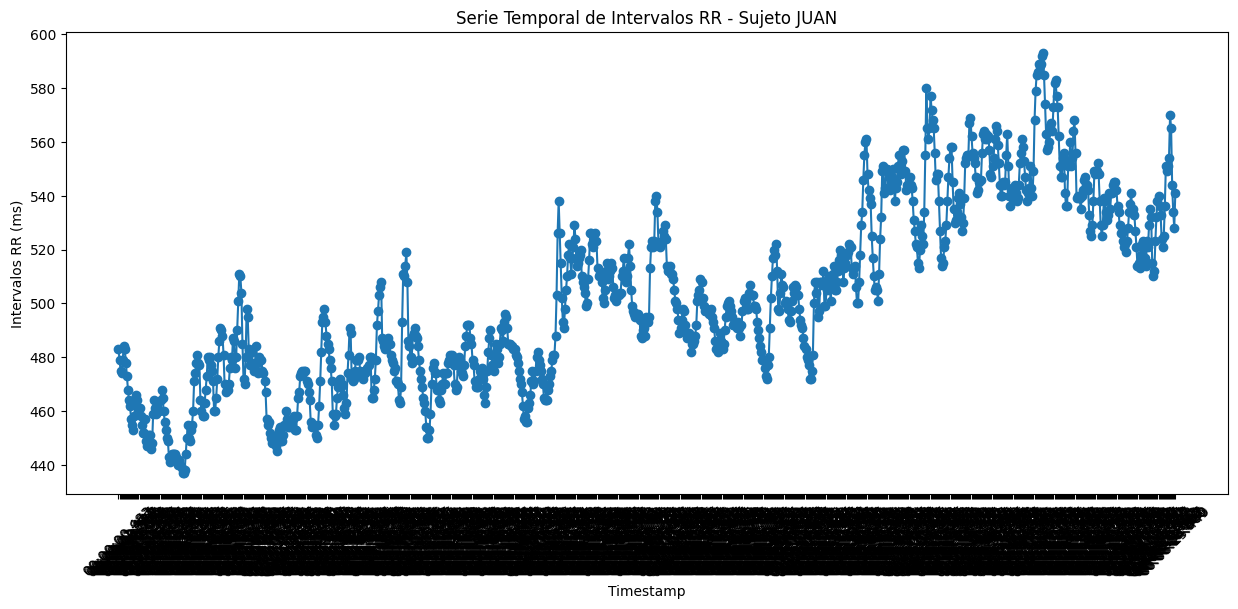

Valores nulos en los datos del sujeto JUAN:
RR           0
timestamp    0
dtype: int64
Registros duplicados en los datos del sujeto JUAN: 0

Análisis del sujeto: RACHEL
Primeras 5 filas de datos:
    RR     timestamp
0  521  00:00:00.521
1  510  00:00:01.031
2  496  00:00:01.527
3  497  00:00:02.024
4  501  00:00:02.525

Resumen estadístico:
count    1561.000000
mean      544.623959
std        66.416567
min       396.000000
25%       498.000000
50%       537.000000
75%       594.000000
max       754.000000
Name: RR, dtype: float64


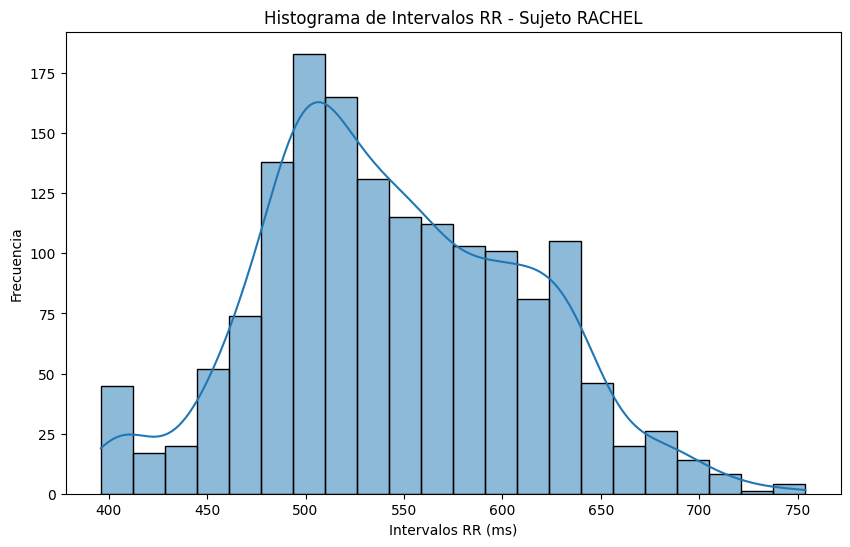

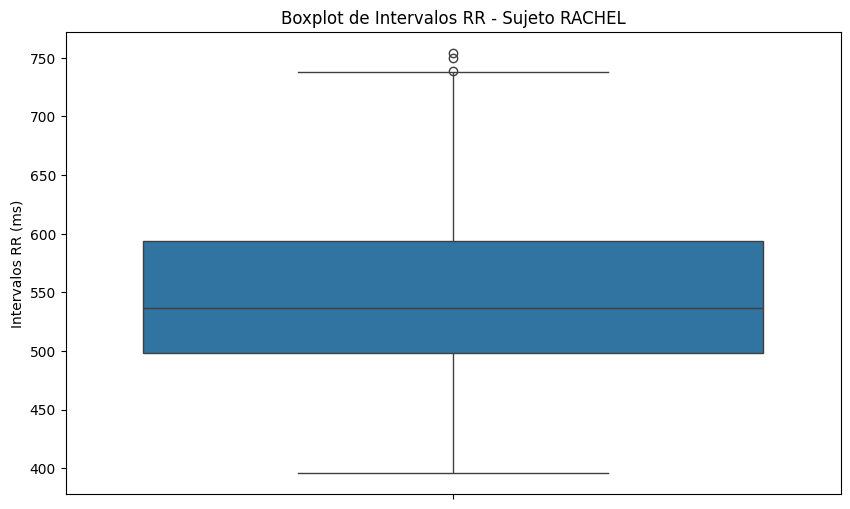

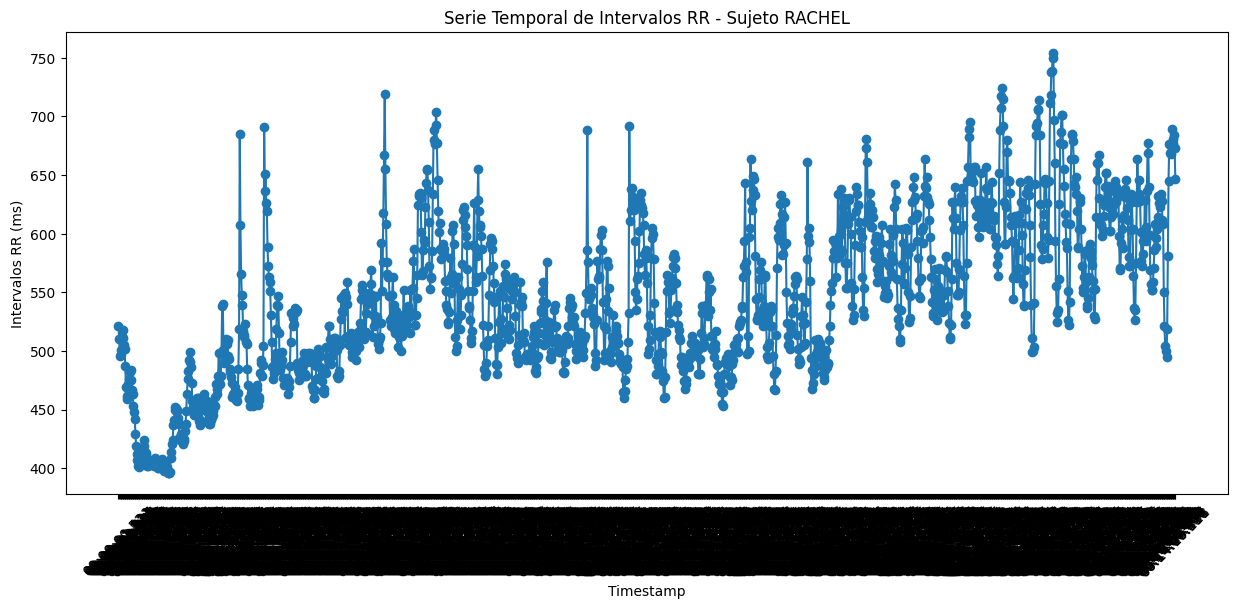

Valores nulos en los datos del sujeto RACHEL:
RR           0
timestamp    0
dtype: int64
Registros duplicados en los datos del sujeto RACHEL: 0

Análisis del sujeto: SCARLETT
Primeras 5 filas de datos:
    RR     timestamp
0  426  00:00:00.426
1  424  00:00:00.850
2  420  00:00:01.270
3  422  00:00:01.692
4  424  00:00:02.116

Resumen estadístico:
count    1152.000000
mean      418.614583
std       113.315391
min       372.000000
25%       388.000000
50%       403.000000
75%       430.000000
max      2725.000000
Name: RR, dtype: float64


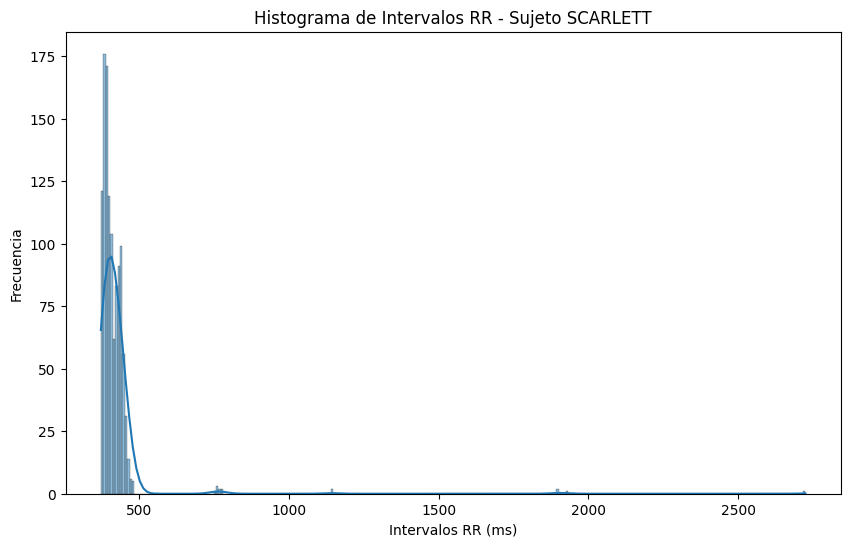

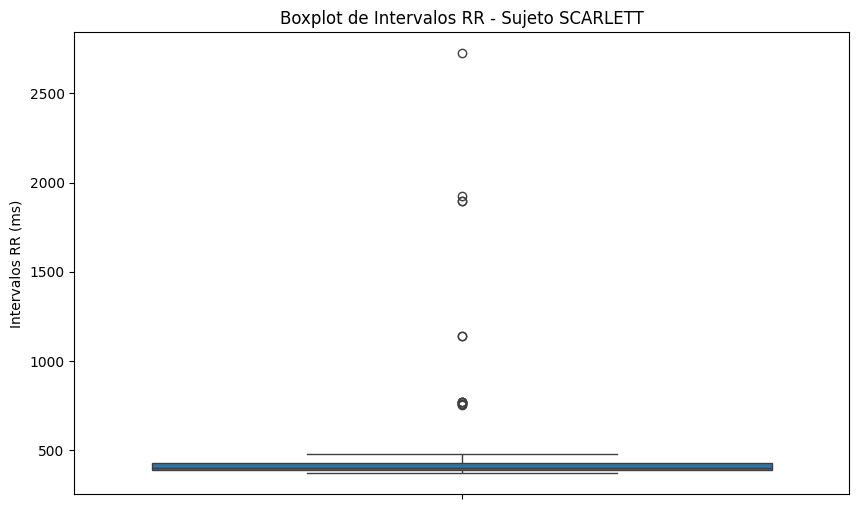

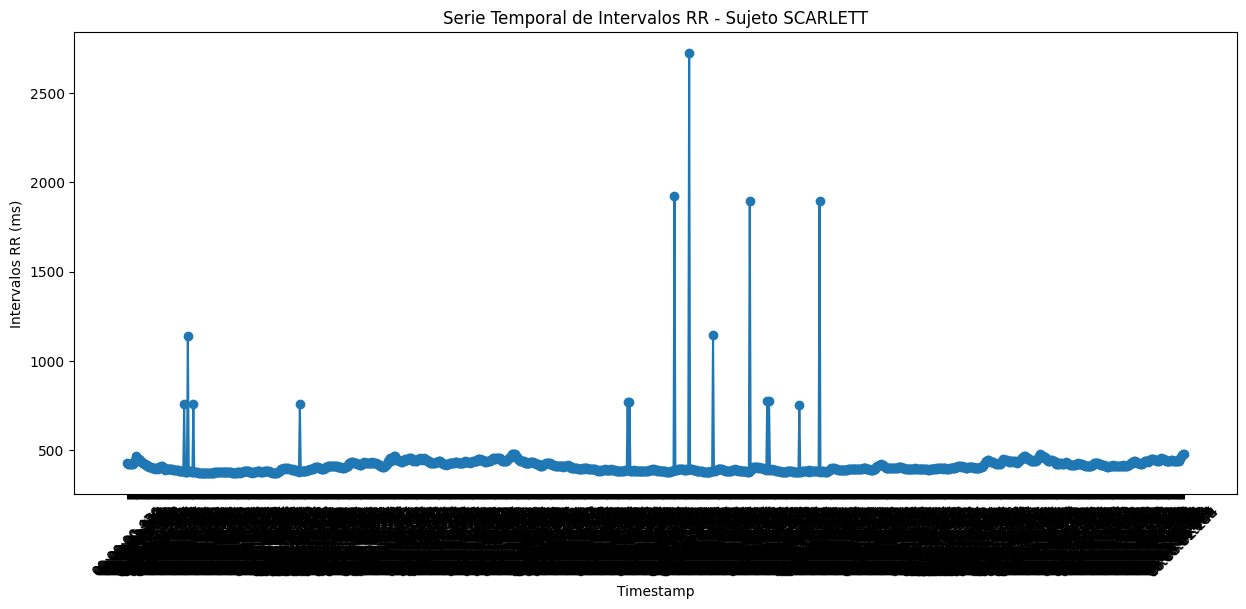

Valores nulos en los datos del sujeto SCARLETT:
RR           0
timestamp    0
dtype: int64
Registros duplicados en los datos del sujeto SCARLETT: 0



In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Iterar sobre cada sujeto en el diccionario fisiological_data
for subject, df in fisiological_data.items():
    print(f"Análisis del sujeto: {subject}")
    print("Primeras 5 filas de datos:")
    print(df.head())
    
    # Descripción estadística
    print("\nResumen estadístico:")
    print(df['RR'].describe())
    
    # Histograma de los intervalos RR
    plt.figure(figsize=(10, 6))
    sns.histplot(df['RR'], kde=True)
    plt.title(f'Histograma de Intervalos RR - Sujeto {subject}')
    plt.xlabel('Intervalos RR (ms)')
    plt.ylabel('Frecuencia')
    plt.show()
    
    # Boxplot de los intervalos RR
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df['RR'])
    plt.title(f'Boxplot de Intervalos RR - Sujeto {subject}')
    plt.ylabel('Intervalos RR (ms)')
    plt.show()
    
    # Serie temporal de los intervalos RR
    plt.figure(figsize=(15, 6))
    plt.plot(df['timestamp'], df['RR'], marker='o', linestyle='-')
    plt.title(f'Serie Temporal de Intervalos RR - Sujeto {subject}')
    plt.xlabel('Timestamp')
    plt.ylabel('Intervalos RR (ms)')
    plt.xticks(rotation=45)
    plt.show()

    # Verificación de valores nulos
    print(f"Valores nulos en los datos del sujeto {subject}:")
    print(df.isnull().sum())

    # Verificación de registros duplicados
    duplicados = df.duplicated().sum()
    print(f"Registros duplicados en los datos del sujeto {subject}: {duplicados}\n")
    
    # Si deseas eliminar duplicados (opcional):
    # df.drop_duplicates(inplace=True)


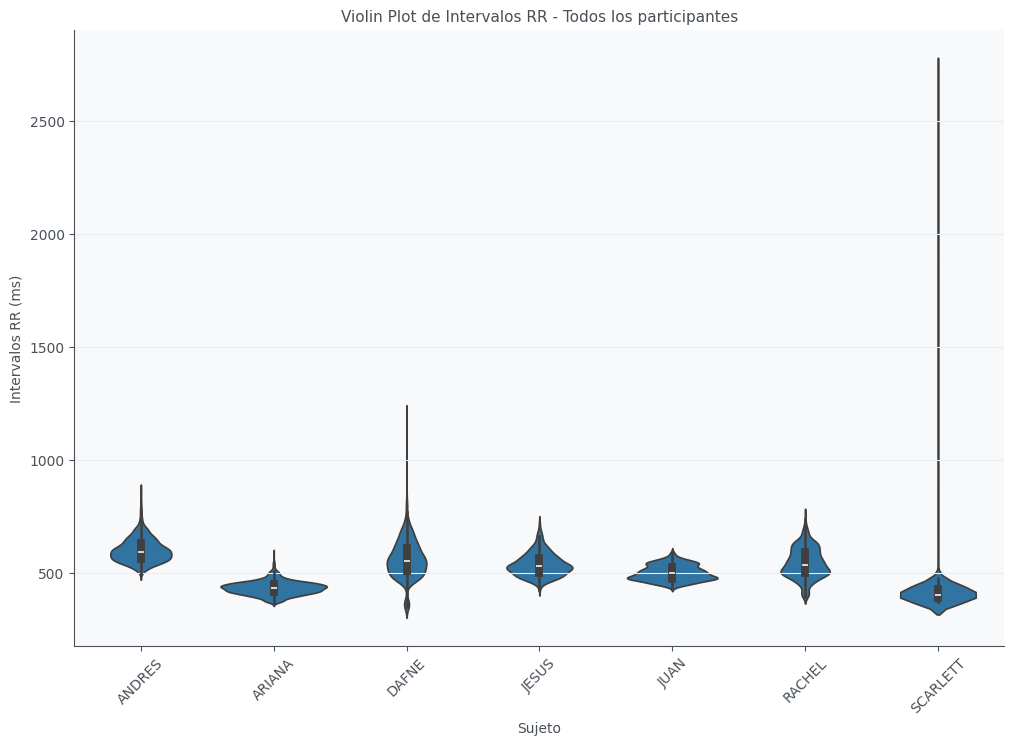

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que fisiological_data es tu diccionario de DataFrames

# Crear una lista para almacenar los DataFrames de cada sujeto
dfs = []

# Iterar sobre cada sujeto en el diccionario fisiological_data
for subject, df in fisiological_data.items():
    # Agregar una nueva columna para identificar el sujeto en cada DataFrame
    df['Sujeto'] = subject
    # Agregar el DataFrame modificado a la lista
    dfs.append(df)

# Concatenar todos los DataFrames en uno solo
combined_df = pd.concat(dfs, ignore_index=True)

# Graficar un gráfico de violín combinado para todos los participantes
plt.figure(figsize=(12, 8))
sns.violinplot(data=combined_df, x='Sujeto', y='RR')
plt.title('Violin Plot de Intervalos RR - Todos los participantes')
plt.xlabel('Sujeto')
plt.ylabel('Intervalos RR (ms)')
plt.xticks(rotation=45)
plt.show()





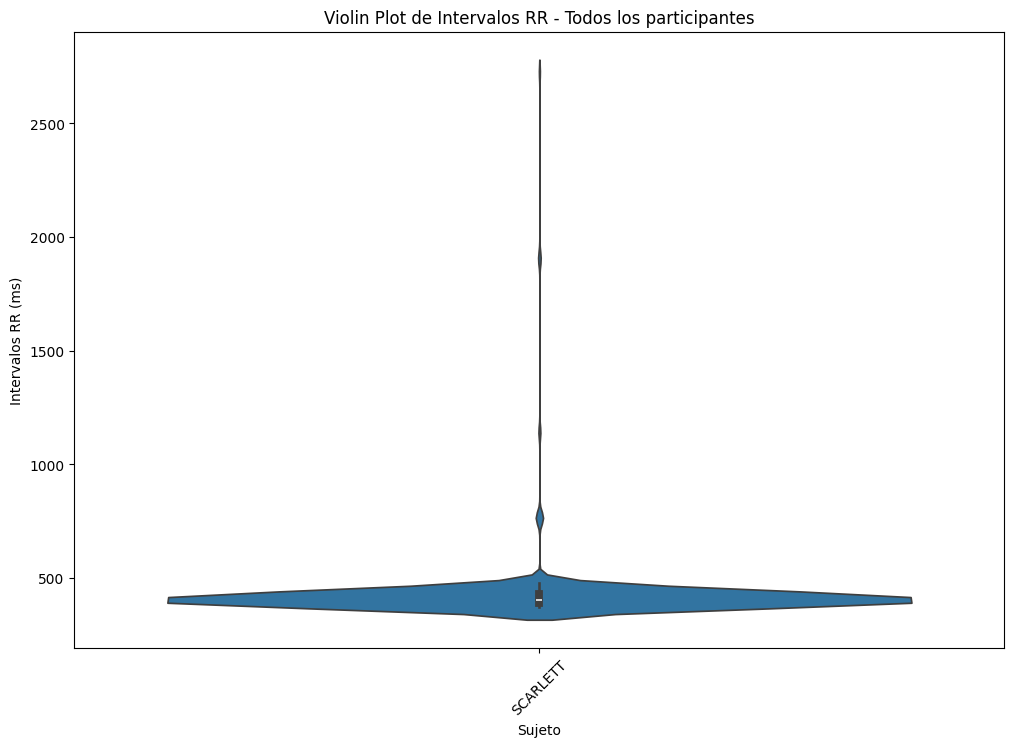

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

dfs = []

# Iterar sobre cada sujeto en el diccionario fisiological_data
for subject, df in fisiological_data.items():
    # Agregar una nueva columna para identificar el sujeto en cada DataFrame
    df['Sujeto'] = subject
    # Agregar el DataFrame modificado a la lista
    dfs.append(df)

# Concatenar todos los DataFrames en uno solo
combined_df = pd.concat(dfs, ignore_index=True)

# Graficar un boxplot combinado para todos los participantes
plt.figure(figsize=(12, 8))
sns.violinplot(df, x='Sujeto', y='RR')
plt.title('Violin Plot de Intervalos RR - Todos los participantes')
plt.xlabel('Sujeto')
plt.ylabel('Intervalos RR (ms)')
plt.xticks(rotation=45)
plt.show()

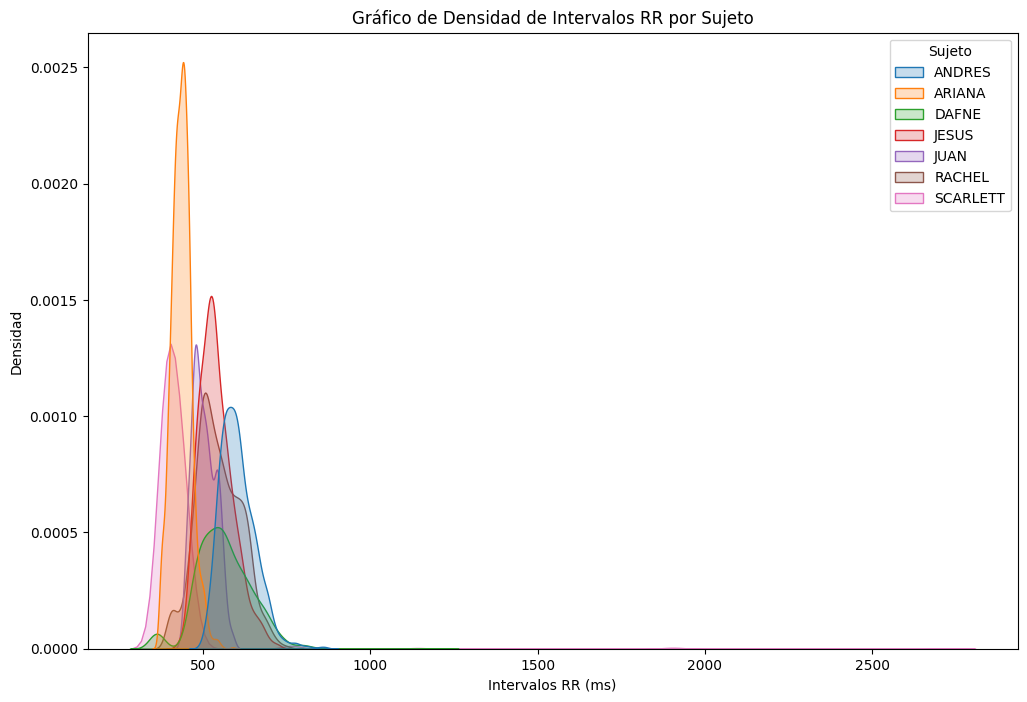

In [16]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=combined_df, x='RR', hue='Sujeto', fill=True)
plt.title('Gráfico de Densidad de Intervalos RR por Sujeto')
plt.xlabel('Intervalos RR (ms)')
plt.ylabel('Densidad')
plt.show()

## Segmentaci&oacute;n y Extracci&oacute;n de Caracter&iacute;sticas

In [17]:
import numpy as np
import pyhrv.time_domain as td
import pandas as pd
caracteristicas_hrv = [
    "nni_counter", "nni_mean", "nni_min", "nni_max",
    "hr_mean", "hr_min", "hr_max", "hr_std",
    "nni_diff_mean", "nni_diff_min", "nni_diff_max",
    "sdnn", "sdnn_index", "sdann", "rmssd", "sdsd",
    "nn50", "pnn50", "nn20", "pnn20",
    "nni_histogram", "tinn_n", "tinn_m", "tinn", "tri_index"
]
def extraer_caracteristicas_hrv_tiempo(rr_intervals):
    # Asegúrate de que los intervalos RR estén en formato numpy array
    rr_intervals = np.array(rr_intervals)
    
    # Calcula características del dominio del tiempo
    time_domain_results = td.time_domain(nni=rr_intervals, plot=False)
    
    # Extraemos el diccionario de resultados
    resultados = pd.DataFrame([time_domain_results], columns=caracteristicas_hrv)  # [1] contiene el diccionario con los resultados
    
    return resultados

def obtener_intervalos_rr_por_ventana(df):
    # Agrupa el DataFrame por las columnas 'inicio_ventana' y 'fin_ventana'
    grupos = df.groupby(['inicio_ventana', 'fin_ventana'])
    
    # Para cada grupo, extrae los intervalos RR como una lista
    intervalos_rr_por_ventana = grupos.apply(lambda x: x['RR'].tolist()).reset_index(name='RR')
    
    return intervalos_rr_por_ventana["RR"]

In [21]:
import pandas as pd

# Asumiendo que fisiological_data es un diccionario que contiene tus DataFrames

for subject in fisiological_data:
    df = fisiological_data[subject]
    # Convertir la columna 'timestamp' a datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Ordenar el DataFrame por 'timestamp'
    df = df.sort_values('timestamp')

    # Lista para almacenar los resultados
    resultados = []
    # Inicializar las variables de inicio y fin de ventana
    inicio_ventana = df.iloc[0]['timestamp']
    fin_ventana = inicio_ventana + pd.Timedelta(minutes=1)

    # Iterar sobre las filas del DataFrame
    for index, row in df.iterrows():
        if row['timestamp'] <= fin_ventana:
            # La muestra actual pertenece a la ventana actual
            resultados.append(row.to_dict())
        else:
            # Actualizar las variables de inicio y fin para la nueva ventana
            inicio_ventana = row['timestamp']
            fin_ventana = inicio_ventana + pd.Timedelta(minutes=1)
            resultados.append(row.to_dict())

    # Convertir los resultados a DataFrame
    resultados_df = pd.DataFrame(resultados)

    # Agregar columnas de inicio y fin de ventana
    resultados_df['inicio_ventana'] = resultados_df['timestamp'].apply(lambda x: x.floor('T'))
    resultados_df['fin_ventana'] = resultados_df['inicio_ventana'] + pd.Timedelta(minutes=1) - pd.Timedelta(seconds=0.001)
    fisiological_data[subject] = resultados_df


In [22]:
features_df = []
for subject in fisiological_data:
    df = fisiological_data[subject]
    intervalos_rr = obtener_intervalos_rr_por_ventana(df)
    feature_instance = []
    for interval in intervalos_rr:
        features = extraer_caracteristicas_hrv_tiempo(interval)
        # Agrega una nueva columna al DataFrame 'features' con el valor de 'subject'
        features['sujeto'] = subject
        # Asegúrate de que las columnas estén en el orden correcto, con 'sujeto' como la primera columna
        columnas = ['sujeto'] + [col for col in features.columns if col != 'sujeto']
        features = features[columnas]
        feature_instance.append(features)
    features_df.append(pd.concat(feature_instance))

features_df = pd.concat(features_df)
    

In [23]:
features_df

,sujeto,nni_counter,nni_mean,nni_min,nni_max,hr_mean,hr_min,hr_max,hr_std,nni_diff_mean,...,sdsd,nn50,pnn50,nn20,pnn20,nni_histogram,tinn_n,tinn_m,tinn,tri_index
0,ANDRES,103,579.757282,508.0,693.0,103.939770,86.580087,118.110236,6.781413,17.852941,...,14.433457,3,2.941176,34,33.333333,None,500.0000,656.2500,156.2500,9.363636
0,ANDRES,97,615.649485,511.0,785.0,98.051315,76.433121,117.416830,7.711505,23.437500,...,22.017607,10,10.416667,41,42.708333,None,500.0000,703.1250,203.1250,12.125000
0,ANDRES,104,579.192308,514.0,743.0,104.220229,80.753701,116.731518,7.955799,15.805825,...,16.859895,3,2.912621,28,27.184466,None,507.8125,671.8750,164.0625,10.400000
0,ANDRES,97,615.082474,496.0,815.0,98.628084,73.619632,120.967742,10.397382,26.614583,...,29.907707,16,16.666667,37,38.541667,None,492.1875,726.5625,234.3750,12.125000
0,ANDRES,99,610.626263,534.0,866.0,98.952213,69.284065,112.359551,7.964385,19.846939,...,28.535509,5,5.102041,35,35.714286,None,523.4375,632.8125,109.3750,9.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,SCARLETT,137,438.087591,376.0,2725.0,150.189277,22.018349,159.574468,22.461910,103.352941,...,389.536335,12,8.823529,12,8.823529,None,367.1875,406.2500,39.0625,2.795918
0,SCARLETT,148,405.277027,377.0,1896.0,151.574778,31.645570,159.151194,12.196819,27.319728,...,180.656868,4,2.721088,4,2.721088,None,367.1875,406.2500,39.0625,2.846154
0,SCARLETT,142,422.542254,391.0,477.0,142.435833,125.786164,153.452685,7.869639,2.964539,...,2.901752,0,0.000000,0,0.000000,None,375.0000,468.7500,93.7500,4.733333
0,SCARLETT,141,426.900709,406.0,456.0,140.673410,131.578947,147.783251,4.205322,2.557143,...,2.336053,0,0.000000,0,0.000000,None,398.4375,453.1250,54.6875,4.700000


In [26]:
features_df.to_csv('caracteristicas_df')

In [24]:
features_df.isna().sum()

sujeto            0
nni_counter       0
nni_mean          0
nni_min           0
nni_max           0
hr_mean           0
hr_min            0
hr_max            0
hr_std            0
nni_diff_mean     0
nni_diff_min      0
nni_diff_max      0
sdnn              0
sdnn_index       81
sdann            81
rmssd             0
sdsd              0
nn50              0
pnn50             0
nn20              0
pnn20             0
nni_histogram    81
tinn_n            0
tinn_m            0
tinn              0
tri_index         0
dtype: int64

In [25]:
features_df = features_df.drop(columns=['sdnn_index', 'sdann', 'nni_histogram'])
features_df.isna().sum()

sujeto           0
nni_counter      0
nni_mean         0
nni_min          0
nni_max          0
hr_mean          0
hr_min           0
hr_max           0
hr_std           0
nni_diff_mean    0
nni_diff_min     0
nni_diff_max     0
sdnn             0
rmssd            0
sdsd             0
nn50             0
pnn50            0
nn20             0
pnn20            0
tinn_n           0
tinn_m           0
tinn             0
tri_index        0
dtype: int64

## Modelos a Evaluar

In [27]:
df = pd.read_csv("caracteristicas_con_etiquetas.csv")
print(df.head)

<bound method NDFrame.head of     Unnamed: 0    sujeto  nni_counter    nni_mean  nni_min  nni_max  \
0            0    ANDRES          103  579.757282    508.0    693.0   
1            0    ANDRES           97  615.649485    511.0    785.0   
2            0    ANDRES          104  579.192308    514.0    743.0   
3            0    ANDRES           97  615.082474    496.0    815.0   
4            0    ANDRES           99  610.626263    534.0    866.0   
..         ...       ...          ...         ...      ...      ...   
76           0  SCARLETT          137  438.087591    376.0   2725.0   
77           0  SCARLETT          148  405.277027    377.0   1896.0   
78           0  SCARLETT          142  422.542254    391.0    477.0   
79           0  SCARLETT          141  426.900709    406.0    456.0   
80           0  SCARLETT            5  470.000000    459.0    479.0   

       hr_mean      hr_min      hr_max     hr_std  ...        sdsd  nn50  \
0   103.939770   86.580087  118.110236   

In [28]:
df = df.drop(['Unnamed: 0'], axis=1)
X = df.iloc[:, 1:-1]
Y = df.iloc[:, -1]

### Info gain

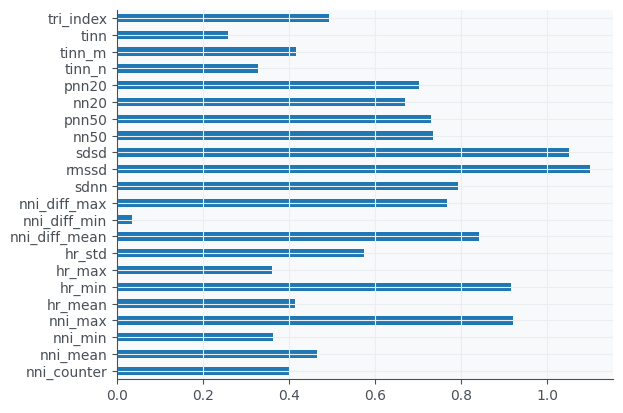

In [29]:
from sklearn.feature_selection import mutual_info_classif


# Asumiendo que X y y ya están definidos como se discutió anteriormente
X_new = mutual_info_classif(X, Y)

# Ajusta las etiquetas de las columnas para que coincidan con las dimensiones de X
# Aquí, utilizamos df.columns[1:-1] para excluir tanto la primera como la última columna de df
feat_imp = pd.Series(X_new, df.columns[1:len(df.columns)-1])

# Graficar la importancia de las características
feat_imp.plot(kind='barh')
plt.show()

In [31]:
# Calcular el valor medio entre 0.2 y 0.3
umbral = (0.4 + 0.5) / 2

# Filtrar las características con valores mayores al umbral
selected_features = features_df.columns[np.where(X_new > umbral)].tolist()

# Mostrar las características seleccionadas
print("Características seleccionadas con valor mayor a", umbral, ":", selected_features)
features_df_info_gain = features_df[selected_features]
features_df_info_gain

Características seleccionadas con valor mayor a 0.45 : ['nni_counter', 'nni_min', 'hr_mean', 'hr_max', 'hr_std', 'nni_diff_min', 'nni_diff_max', 'sdnn', 'rmssd', 'sdsd', 'nn50', 'pnn50', 'nn20', 'tinn']


,nni_counter,nni_min,hr_mean,hr_max,hr_std,nni_diff_min,nni_diff_max,sdnn,rmssd,sdsd,nn50,pnn50,nn20,tinn
0,103,508.0,103.939770,118.110236,6.781413,0,68,38.817437,22.913092,14.433457,3,2.941176,34,156.2500
0,97,511.0,98.051315,117.416830,7.711505,1,124,48.170929,32.078679,22.017607,10,10.416667,41,203.1250
0,104,514.0,104.220229,116.731518,7.955799,0,130,46.387368,23.050388,16.859895,3,2.912621,28,164.0625
0,97,496.0,98.628084,120.967742,10.397382,1,131,65.069461,39.918537,29.907707,16,16.666667,37,234.3750
0,99,534.0,98.952213,112.359551,7.964385,0,206,54.140894,34.639101,28.535509,5,5.102041,35,109.3750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,137,376.0,150.189277,159.574468,22.461910,0,2332,279.621947,401.627516,389.536335,12,8.823529,12,39.0625
0,148,377.0,151.574778,159.151194,12.196819,0,1516,127.262107,182.102311,180.656868,4,2.721088,4,39.0625
0,142,391.0,142.435833,153.452685,7.869639,0,13,23.718390,4.141127,2.901752,0,0.000000,0,93.7500
0,141,406.0,140.673410,147.783251,4.205322,0,10,12.836502,3.457910,2.336053,0,0.000000,0,54.6875


## Evaluando los modelos

In [42]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

encoder = OrdinalEncoder(categories=[['Bajo', 'Moderado', 'Grave']])

Y_2D = Y.values.reshape(-1, 1) 
data_encoded_2D = encoder.fit_transform(Y_2D)  
data_encoded = data_encoded_2D.ravel()  

print(data_encoded)


[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 2. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 0. 0. 2. 0. 0. 0. 2. 2. 2.]


In [43]:
names = [
    "Nearest Neighbors",
    "Naive Bayes",
    "AdaBoost"
]
modelos = [
    KNeighborsClassifier(n_neighbors=6),
    GaussianNB(),
    AdaBoostClassifier()
]

In [44]:
def validacion_cruzada(model, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracies = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        X_test_np = X_test.values
        y_pred = model.predict(X_test_np)

        precision = precision_score(y_test, y_pred, average='weighted')
        precision_scores.append(precision)

        recall = recall_score(y_test, y_pred, average='weighted')
        recall_scores.append(recall)

        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        accuracy = model.score(X_test, y_test)
        accuracies.append(accuracy)

    return np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(accuracies)

resultados = []

for nombre, modelo in zip(names, modelos):
    precision, recall, f1, accuracy = validacion_cruzada(model=modelo, X=X, y=data_encoded)
    resultados.append({"nombre": nombre, "precision": precision, "recall": recall, "f1_score": f1, "accuracy": accuracy})

df_resultados = pd.DataFrame(resultados)

In [45]:
df_resultados

,nombre,precision,recall,f1_score,accuracy
0,Nearest Neighbors,0.894463,0.851471,0.859807,0.851471
1,Naive Bayes,0.929583,0.900000,0.905208,0.900000
2,AdaBoost,0.989583,0.987500,0.987500,0.987500


## Seleccionando el mejor modelo

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, data_encoded, test_size=0.2, random_state=42)
model = AdaBoostClassifier()
model.fit(X_train, y_train)

AdaBoostClassifier()

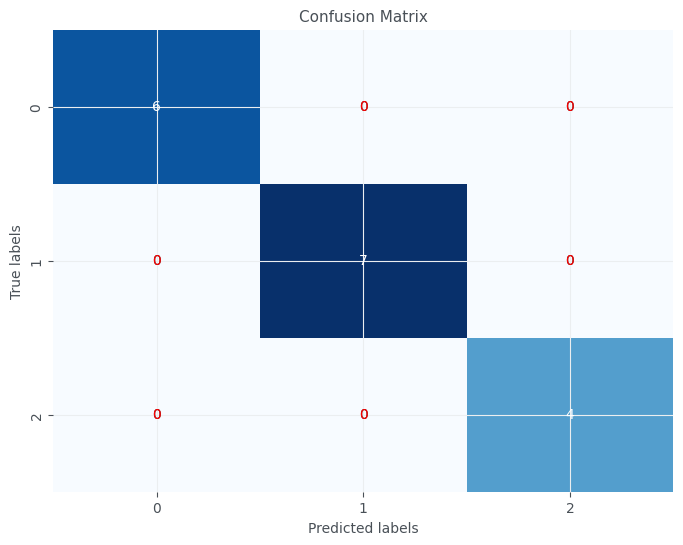

F1 Score: 1.0
Sensibilidad (Recall): 1.0
Especificidad por clase: [1.0, 1.0, 1.0]
Exactitud: 1.0


In [48]:
# Obtener predicciones del modelo
y_pred = model.predict(X_test)

# Calcular la matriz de confusión multiclase
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular métricas adicionales
f1 = f1_score(y_test, y_pred, average='weighted')
sensibilidad = recall_score(y_test, y_pred, average='weighted')
exactitud = accuracy_score(y_test, y_pred)

# Calcular especificidad para cada clase
especificidad = []
for i in range(len(conf_matrix)):
    true_negative = np.sum(np.delete(np.delete(conf_matrix, i, 0), i, 1))
    total_negative = np.sum(np.delete(conf_matrix, i, 0))
    especificidad.append(true_negative / total_negative)

# Visualizar la matriz de confusión con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)

# Resaltar los valores donde el modelo se confundió
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        if i != j:
            plt.text(j + 0.5, i + 0.5, conf_matrix[i, j], ha="center", va="center", color="red")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Imprimir métricas
print("F1 Score:", f1)
print("Sensibilidad (Recall):", sensibilidad)
print("Especificidad por clase:", especificidad)
print("Exactitud:", exactitud)

## Validaci&oacute;n 

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, data_encoded, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Crear y entrenar el modelo AdaBoost
model = AdaBoostClassifier()
model.fit(X_train, y_train)

AdaBoostClassifier()

## Conclusiones